In [1]:
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
from joblib import Parallel, delayed
import seaborn as sbn
%matplotlib widget

In [2]:
luc_sequences = {}
for fasta in SeqIO.parse(open("../../FLuc variants.txt"),'fasta'):
    name, sequence = fasta.id, str(fasta.seq)
    luc_sequences[name] = sequence

all_codons = pd.read_csv("decoding_times/base_configuration.csv", index_col=None).codon.values

In [3]:
def codons(seq):
    n = len(seq)
    for i in range(0, n - 2, 3):
        # ignore start codon
        if i == 0:
            continue
        # ignore termination codon
        if i == n - 3:
            continue
        yield seq[i:i+3].replace('T', 'U')

def create_equation(sequence):
    equation = np.zeros(len(all_codons))
    for codon in codons(sequence):
        equation[np.where(all_codons == codon)] += 1
    return equation

In [4]:
equations = {}
for s in luc_sequences.keys():
    equations[s] = create_equation(luc_sequences[s])

In [5]:
def load_csv_files(decoding_file_name:str):
    if decoding_file_name.endswith(".csv"):
        arr = np.genfromtxt("decoding_times/" + decoding_file_name, delimiter=",", usecols=(1), skip_header=1)
        return (decoding_file_name, arr)


parallel = Parallel(n_jobs=-1, verbose=10)
results = parallel(delayed(load_csv_files)(decoding_file_name) for decoding_file_name in os.listdir("decoding_times/"))

decoding_files_dict = {}
for file_name, arr in results:
    decoding_files_dict[file_name] = arr

all_codons = pd.read_csv("decoding_times/base_configuration.csv", index_col=None).codon.values
baseline_arr = decoding_files_dict['base_configuration.csv']
del decoding_files_dict['base_configuration.csv']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18492421098532308s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1300504207611084s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast 

In [6]:
[np.dot(equations['StaCFLuc'],baseline_arr)/np.dot(equations[construct],baseline_arr) for construct in equations.keys()]

[0.7665051782209209, 1.0, 2.589036492002439]

In [7]:
equations_df = pd.DataFrame({"codon": all_codons, "MinCFLuc":equations['MinCFLuc'], 'StaCFLuc':equations['StaCFLuc']}).set_index('codon')
equations_df

MinCFLuc  StaCFLuc
codon                    
AAA        39.0      25.0
AAC        10.0      10.0
AAG         0.0      14.0
AAU         9.0       9.0
ACA         0.0       9.0
...         ...       ...
UGU         2.0       2.0
UUA         0.0      11.0
UUC        12.0      12.0
UUG         0.0      13.0
UUU        18.0      18.0

[61 rows x 2 columns]

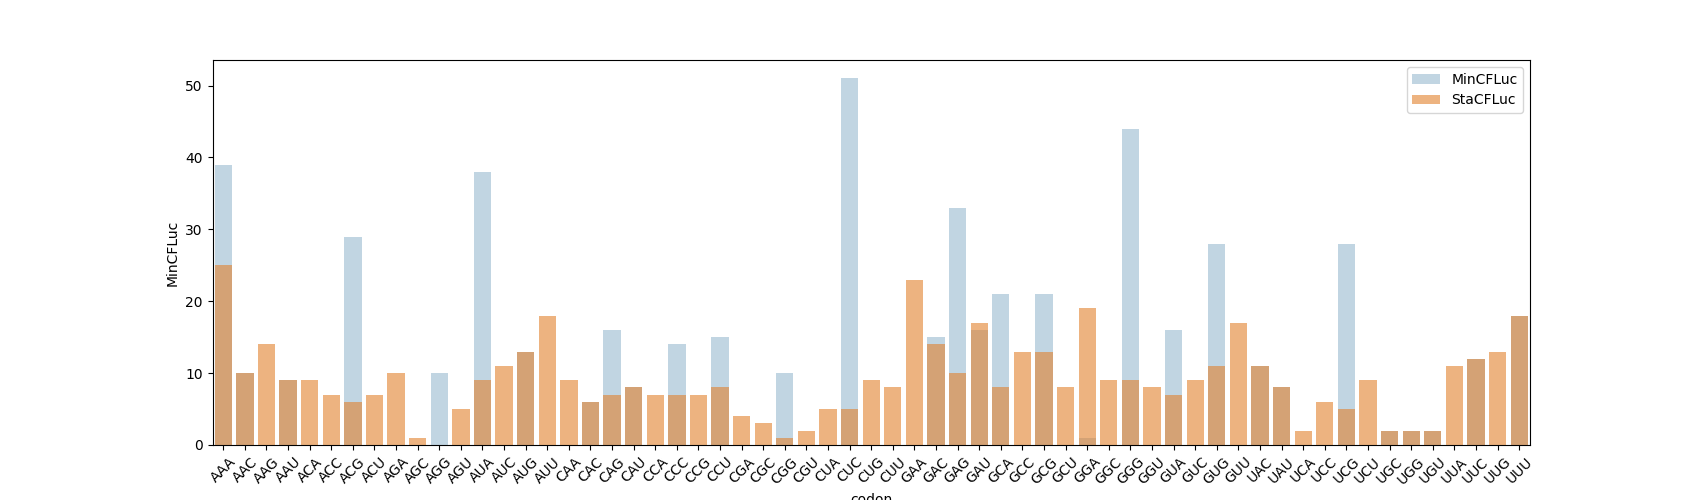

In [8]:
plt.figure(figsize=(17,5))
sbn.barplot(equations_df, x='codon', y='MinCFLuc', label='MinCFLuc', alpha=0.3)
sbn.barplot(equations_df, x='codon', y='StaCFLuc', label='StaCFLuc', alpha=0.6)
plt.xticks(rotation=45);
plt.legend()
plt.show()

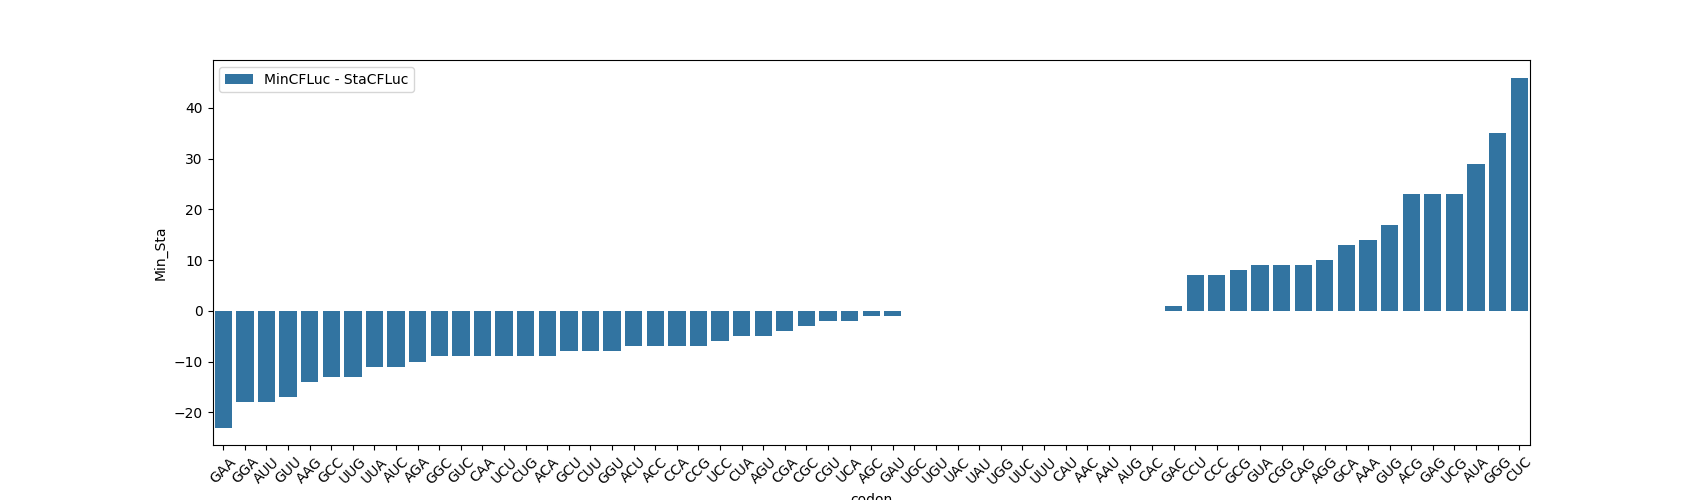

In [9]:
min_sta_df = pd.DataFrame({"codon": all_codons, "Min_Sta":equations['MinCFLuc'] - equations['StaCFLuc']}).set_index('codon').sort_values('Min_Sta')
plt.figure(figsize=(17,5))
sbn.barplot(min_sta_df, x='codon', y='Min_Sta', label='MinCFLuc - StaCFLuc')
plt.xticks(rotation=45)
plt.show()

In [10]:
def codon_index(codon):
    return np.argwhere(all_codons == codon)[0][0]

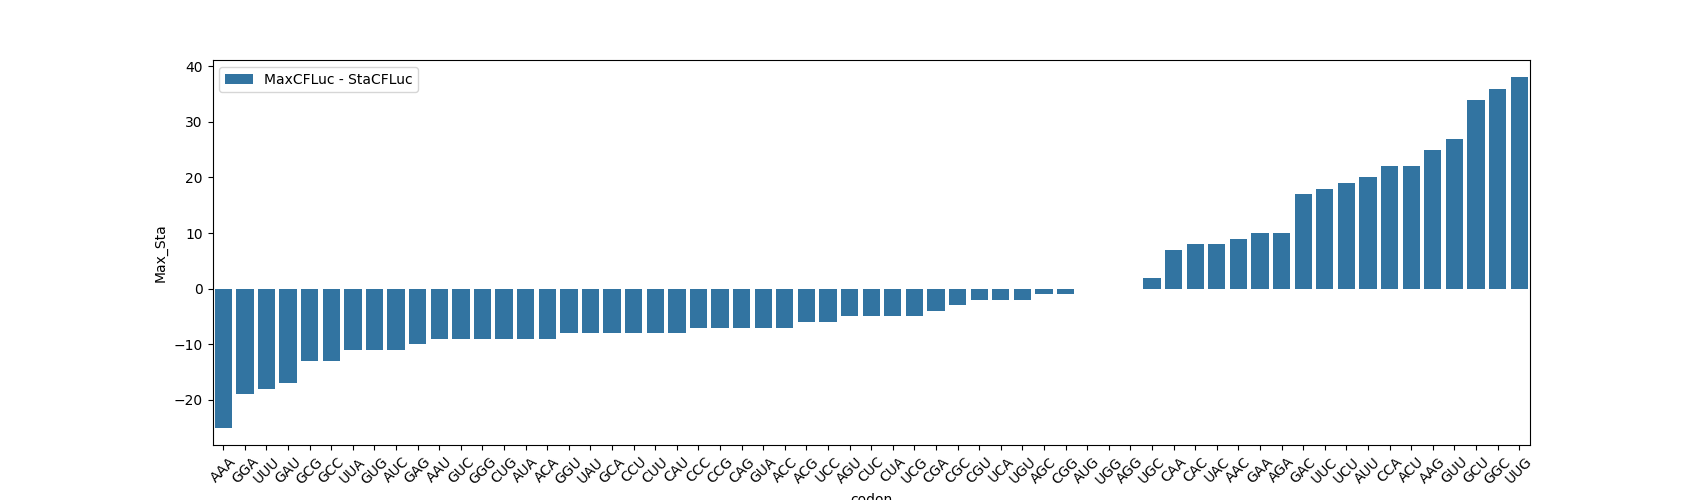

In [11]:
min_sta_df = pd.DataFrame({"codon": all_codons, "Max_Sta":equations['MaxCFLuc'] - equations['StaCFLuc']}).set_index('codon').sort_values('Max_Sta')
plt.figure(figsize=(17,5))
sbn.barplot(min_sta_df, x='codon', y='Max_Sta', label='MaxCFLuc - StaCFLuc')
plt.xticks(rotation=45)
plt.show()

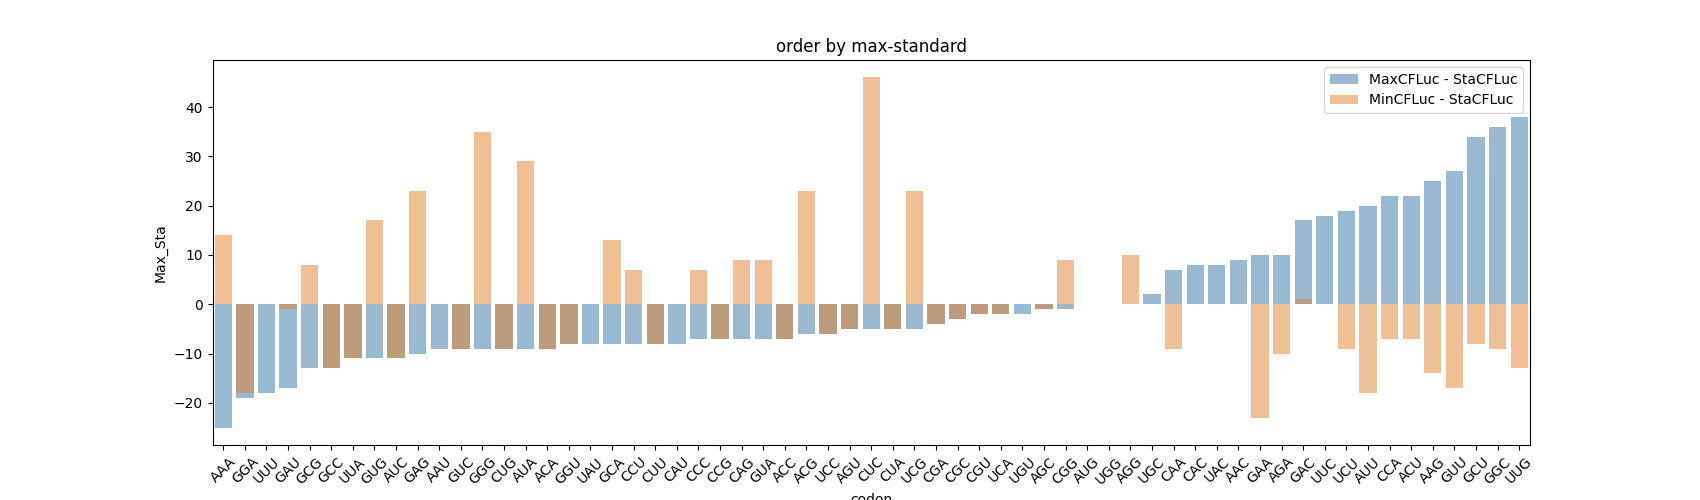

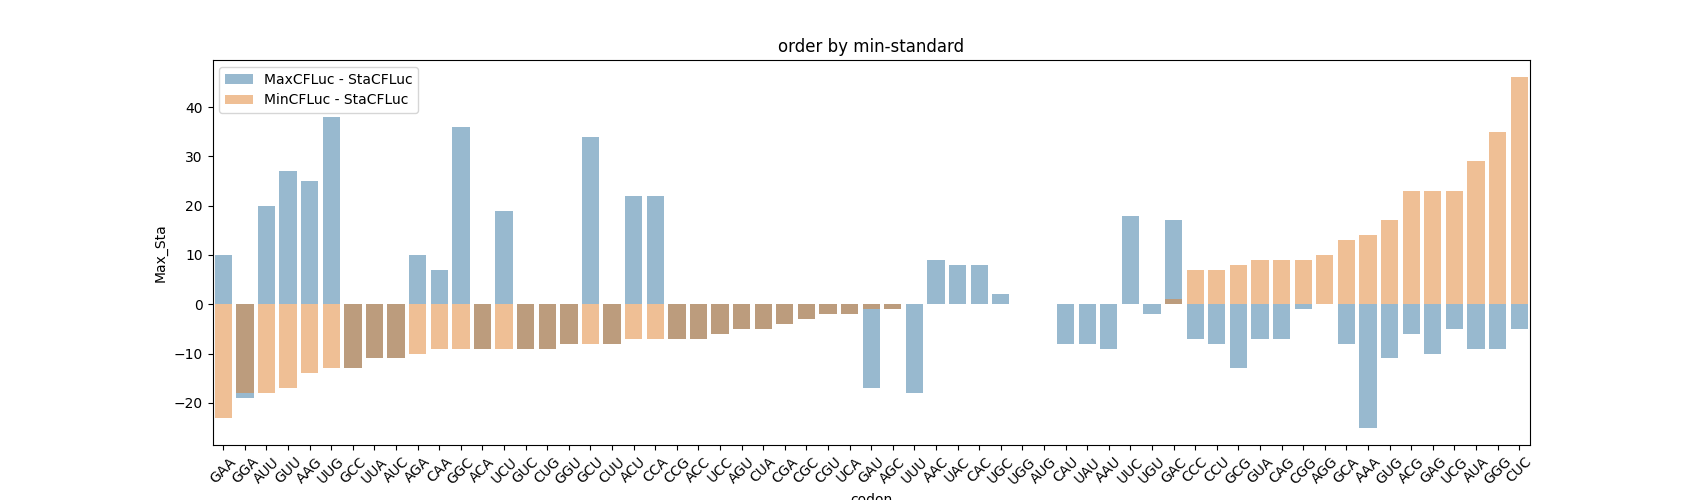

In [12]:
df = pd.DataFrame({"codon": all_codons, "Min_Sta":equations['MinCFLuc'] - equations['StaCFLuc'], "Max_Sta":equations['MaxCFLuc'] - equations['StaCFLuc']}).set_index('codon').sort_values('Max_Sta')
plt.figure(figsize=(17,5))
plt.title("order by max-standard")
sbn.barplot(df, x='codon', y='Max_Sta', label='MaxCFLuc - StaCFLuc', alpha=0.5)
sbn.barplot(df, x='codon', y='Min_Sta', label='MinCFLuc - StaCFLuc', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

df = df.sort_values('Min_Sta')
plt.figure(figsize=(17,5))
plt.title("order by min-standard")
sbn.barplot(df, x='codon', y='Max_Sta', label='MaxCFLuc - StaCFLuc', alpha=0.5)
sbn.barplot(df, x='codon', y='Min_Sta', label='MinCFLuc - StaCFLuc', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

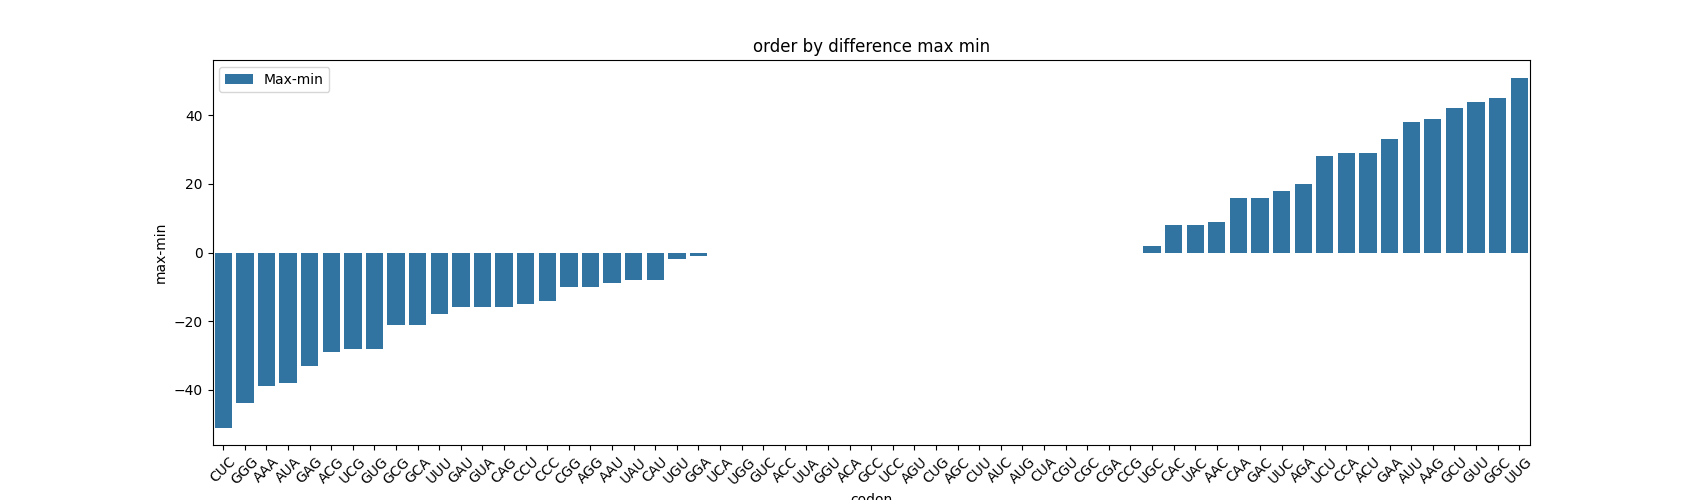

In [13]:
df1 = pd.DataFrame({"codon": all_codons, "Min_Sta":equations['MinCFLuc'] - equations['StaCFLuc'], "Max_Sta":equations['MaxCFLuc'] - equations['StaCFLuc']}).set_index('codon')
# df1["max-min"] = df1['Max_Sta'] - df1['Min_Sta']
df1["max-min"] = equations['MaxCFLuc'] - equations['MinCFLuc']
df1 = df1.sort_values('max-min')
plt.figure(figsize=(17,5))
plt.title("order by difference max min")
sbn.barplot(df1, x='codon', y='max-min', label='Max-min', alpha=1)
# sbn.barplot(df, x='codon', y='Min_Sta', label='MinCFLuc - StaCFLuc', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

In [14]:
# dec_times = np.ones(len(all_codons))*0.3
# # abundant in MinCF
# dec_times[codon_index('CUC')] = 40
# dec_times[codon_index('GGG')] = 30
# dec_times[codon_index('AAA')] = 20
# dec_times[codon_index('AUA')] = 12
# dec_times[codon_index('GAG')] = 13

# #abundant in MaxCF
# dec_times[codon_index('UUG')] = 5
# dec_times[codon_index('GGC')] = 5
# dec_times[codon_index('GUU')] = 3.7


# print("expression levels: ")
# print("minCF: " + str( np.dot(equations['StaCFLuc'], dec_times)/np.dot(equations['MinCFLuc'], dec_times)) + ", target = 0.28")
# print("maxCF: " + str(np.dot(equations['StaCFLuc'], dec_times)/np.dot(equations['MaxCFLuc'], dec_times)) + ", target = 1.9")

In [15]:
A = np.matrix([equations['MinCFLuc'], equations['StaCFLuc'], equations['MaxCFLuc']])
b = np.array([546/0.28, 546, 546/1.9])
b

array([1950.        ,  546.        ,  287.36842105])

In [16]:
np.dot(A, A.T)

matrix([[14612.,  5429.,  1489.],
        [ 5429.,  6512.,  6601.],
        [ 1489.,  6601., 18470.]])

In [17]:
from scipy.linalg import solve
from numpy.linalg import inv

In [18]:
solve(np.dot(A, A.T), b.T)

array([ 0.16106258, -0.08317178,  0.03229904])

In [19]:
s1 = np.dot(A.T, np.dot(A*A.T, b).T)
s1

matrix([[1.64451102e+09],
        [7.03737889e+08],
        [6.85346532e+08],
        [4.31320919e+08],
        [1.44351189e+08],
        [1.12273147e+08],
        [1.02091437e+09],
        [4.54919478e+08],
        [3.96698024e+08],
        [1.60390209e+07],
        [3.18855256e+08],
        [8.01951047e+07],
        [1.35600116e+09],
        [1.76429230e+08],
        [7.76619184e+08],
        [7.37687225e+08],
        [3.33397440e+08],
        [4.52962749e+08],
        [6.22441556e+08],
        [3.83396372e+08],
        [4.54919478e+08],
        [5.58670505e+08],
        [1.12273147e+08],
        [6.06595051e+08],
        [6.41560838e+07],
        [4.81170628e+07],
        [3.34894277e+08],
        [3.20780419e+07],
        [8.01951047e+07],
        [1.70635691e+09],
        [1.44351189e+08],
        [1.28312168e+08],
        [7.58805376e+08],
        [1.06910629e+09],
        [1.21261255e+09],
        [7.82831765e+08],
        [7.97908205e+08],
        [2.08507272e+08],
        [8.7

In [20]:
# np.dot(equations['StaCFLuc'], s1.ravel())/np.dot(equations['MaxCFLuc'], s1.ravel())

In [21]:
# xx = np.array(s1.flatten())
# xx[0]

In [22]:
# np.dot(equations['StaCFLuc'], xx[0])/np.dot(equations['MinCFLuc'], xx[0])

In [23]:
import sympy as sym

In [24]:
display(sym.Matrix(A))

Matrix([
[39.0, 10.0,    0, 9.0,   0,   0, 29.0,    0,    0,   0, 10.0,   0, 38.0,    0, 13.0,    0,    0,  6.0, 16.0, 8.0,    0, 14.0,   0, 15.0,   0,   0, 10.0,   0,   0, 51.0,   0,   0,    0, 15.0, 33.0, 16.0, 21.0,    0, 21.0,    0,  1.0,    0, 44.0,   0, 16.0,   0, 28.0,    0, 11.0, 8.0,   0,   0, 28.0,    0, 2.0, 2.0, 2.0,    0, 12.0,    0, 18.0],
[25.0, 10.0, 14.0, 9.0, 9.0, 7.0,  6.0,  7.0, 10.0, 1.0,    0, 5.0,  9.0, 11.0, 13.0, 18.0,  9.0,  6.0,  7.0, 8.0,  7.0,  7.0, 7.0,  8.0, 4.0, 3.0,  1.0, 2.0, 5.0,  5.0, 9.0, 8.0, 23.0, 14.0, 10.0, 17.0,  8.0, 13.0, 13.0,  8.0, 19.0,  9.0,  9.0, 8.0,  7.0, 9.0, 11.0, 17.0, 11.0, 8.0, 2.0, 6.0,  5.0,  9.0, 2.0, 2.0, 2.0, 11.0, 12.0, 13.0, 18.0],
[   0, 19.0, 39.0,   0,   0,   0,    0, 29.0, 20.0,   0,    0,   0,    0,    0, 13.0, 38.0, 16.0, 14.0,    0,   0, 29.0,    0,   0,    0,   0,   0,    0,   0,   0,    0,   0,   0, 33.0, 31.0,    0,    0,    0,    0,    0, 42.0,    0, 45.0,    0,   0,    0,   0,    0, 44.0, 19.0,   0,   0,   0,   

In [25]:
all_codons

array(['AAA', 'AAC', 'AAG', 'AAU', 'ACA', 'ACC', 'ACG', 'ACU', 'AGA',
       'AGC', 'AGG', 'AGU', 'AUA', 'AUC', 'AUG', 'AUU', 'CAA', 'CAC',
       'CAG', 'CAU', 'CCA', 'CCC', 'CCG', 'CCU', 'CGA', 'CGC', 'CGG',
       'CGU', 'CUA', 'CUC', 'CUG', 'CUU', 'GAA', 'GAC', 'GAG', 'GAU',
       'GCA', 'GCC', 'GCG', 'GCU', 'GGA', 'GGC', 'GGG', 'GGU', 'GUA',
       'GUC', 'GUG', 'GUU', 'UAC', 'UAU', 'UCA', 'UCC', 'UCG', 'UCU',
       'UGC', 'UGG', 'UGU', 'UUA', 'UUC', 'UUG', 'UUU'], dtype=object)

In [26]:
display(sym.Matrix(b))

Matrix([
[          1950.0],
[           546.0],
[287.368421052632]])

In [27]:
from scipy.optimize import lsq_linear

In [28]:
res = lsq_linear(A, b, bounds=(0.001, 10), lsmr_tol=None, verbose=2)

   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         4.3494e+04                                    2.98e+04    
       1         8.5916e+03      3.49e+04       7.92e+00       5.07e+03    
       2         8.2873e+02      7.76e+03       4.70e+00       1.10e+03    
       3         2.0916e+01      8.08e+02       2.15e+00       1.49e+02    
       4         2.5033e-02      2.09e+01       3.83e-01       5.08e+00    
       5         4.1662e-08      2.50e-02       1.35e-02       6.75e-03    
       6         1.1747e-19      4.17e-08       1.72e-05       1.17e-08    
       7         6.4623e-27      1.17e-19       2.88e-11       7.81e-12    
The first-order optimality measure is less than `tol`.
Number of iterations 8, initial cost 4.3494e+04, final cost 6.4623e-27, first-order optimality 7.81e-12.


In [29]:
res.x

array([1.73354201, 0.79546349, 0.05769187, 0.27869115, 0.27431086,
       0.21365614, 6.41094527, 0.22230397, 0.09875557, 0.03746352,
       9.377731  , 0.15300143, 6.89644205, 0.33496558, 0.71908797,
       0.14451861, 0.11963912, 0.55011757, 0.84953133, 0.2477925 ,
       0.22230397, 0.70658356, 0.21365614, 0.73530676, 0.12267407,
       0.09234671, 5.32498855, 0.06201935, 0.15300143, 9.8005793 ,
       0.27431086, 0.2439835 , 0.41392271, 1.34158535, 1.37797019,
       0.45992464, 1.14797766, 0.39562029, 0.95275041, 1.92436473,
       0.52136074, 0.45583716, 7.63576621, 0.2439835 , 0.84953133,
       0.27431086, 1.52604063, 0.05667191, 0.8225566 , 0.2477925 ,
       0.06201935, 0.18332878, 6.51620183, 0.09123124, 0.16498571,
       0.1110506 , 0.06240061, 0.33496558, 1.15616594, 0.35003813,
       0.556779  ])

In [30]:
xx = res.x
print("expression levels: ")
print("minCF: " + str( np.dot(equations['StaCFLuc'], xx)/np.dot(equations['MinCFLuc'], xx)) + ", target = 0.28")
print("maxCF: " + str(np.dot(equations['StaCFLuc'], xx)/np.dot(equations['MaxCFLuc'], xx)) + ", target = 1.9")

expression levels: 
minCF: 0.28, target = 0.28
maxCF: 1.8999999999999995, target = 1.9


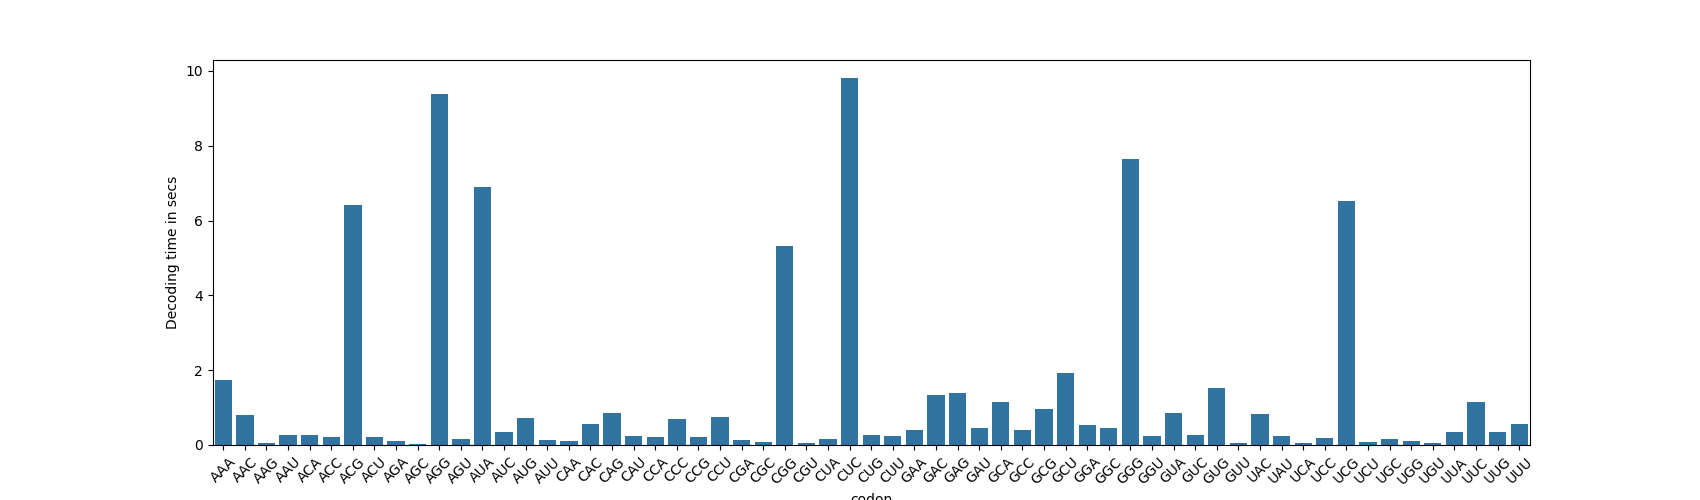

In [31]:
plt.figure(figsize=(17,5))
sbn.barplot(pd.DataFrame({"codon": all_codons, "decoding_time":xx}), x='codon', y='decoding_time',  alpha=1)
plt.xticks(rotation=45)
plt.ylabel('Decoding time in secs')
plt.show()


In [32]:
pd.DataFrame({'codon':all_codons, 'decoding_time':xx}).to_csv('linear_regression_estimation-TWO_rules_cerevisiae.csv', index=None)

In [33]:
xx

array([1.73354201, 0.79546349, 0.05769187, 0.27869115, 0.27431086,
       0.21365614, 6.41094527, 0.22230397, 0.09875557, 0.03746352,
       9.377731  , 0.15300143, 6.89644205, 0.33496558, 0.71908797,
       0.14451861, 0.11963912, 0.55011757, 0.84953133, 0.2477925 ,
       0.22230397, 0.70658356, 0.21365614, 0.73530676, 0.12267407,
       0.09234671, 5.32498855, 0.06201935, 0.15300143, 9.8005793 ,
       0.27431086, 0.2439835 , 0.41392271, 1.34158535, 1.37797019,
       0.45992464, 1.14797766, 0.39562029, 0.95275041, 1.92436473,
       0.52136074, 0.45583716, 7.63576621, 0.2439835 , 0.84953133,
       0.27431086, 1.52604063, 0.05667191, 0.8225566 , 0.2477925 ,
       0.06201935, 0.18332878, 6.51620183, 0.09123124, 0.16498571,
       0.1110506 , 0.06240061, 0.33496558, 1.15616594, 0.35003813,
       0.556779  ])